# Compare analyzers on ImageNet

In this notebook we show how one can use **iNNvestigate** to analyze the prediction of ImageNet-models! To do so we will load a network from the keras.applications module and analyze prediction on some images!

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb) and [Comparing methods on MNIST](mnist_method_comparison.ipynb)

-----

**To use this notebook please download the example images using the following script:**

`innvestigate/examples/images/wget_imagenet_2011_samples.sh`

## Imports

In [1]:
#%load_ext autoreload
#%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import imp
import numpy as np
import os

import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
import tensorflow.keras.models as keras_models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

## Model

In this demo use the VGG16-model, which uses ReLU activation layers.

In [3]:
# Load the model definition.
tmp = getattr(innvestigate.applications.imagenet, os.environ.get("NETWORKNAME", "vgg16"))
net = tmp(load_weights=True, load_patterns="relu")

# Build the model.
model = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")

# Handle input depending on model and backend.
channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
553385984/553380098 [==============================] - 45s 0us/step


## Data

Now we load some example images and preprocess them to fit the input size model.

To analyze your own example images, just add them to `innvestigate/examples/images`.

In [4]:
# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data(net["image_shape"][0])

if not len(images):
    raise Exception("Please download the example images using: "
                    "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'")

## Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`.

Note: Should you run into resource trouble, e.g. you are running that notebook on a computer without GPU or with only limited GPU memory, consider deactivating one or more analyzers by commenting the corresponding lines in the next cell.

In [5]:
patterns = net["patterns"]
input_range = net["input_range"]

noise_scale = (input_range[1]-input_range[0]) * 0.1

# Methods we use and some properties.
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
    # Show input.
    ("input",                 {},                       imgnetutils.image,         "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},   imgnetutils.graymap,       "Gradient"),
    #("smoothgrad",            {"augment_by_n": 64,
    #                           "noise_scale": noise_scale,
    #                           "postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"),

    # Signal
    ("deconvnet",             {},                       imgnetutils.bk_proj,       "Deconvnet"),
    ("guided_backprop",       {},                       imgnetutils.bk_proj,       "Guided Backprop",),
    #("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj,       "PatternNet"),

    # Interaction
    #("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap,       "PatternAttribution"),
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, imgnetutils.heatmap,       "DeepTaylor"),
    #("input_t_gradient",      {},                       imgnetutils.heatmap,       "Input * Gradient"),
    #("integrated_gradients",  {"reference_inputs": input_range[0],
    #                           "steps": 64},            imgnetutils.heatmap,       "Integrated Gradients"),
    ("lrp.z",                 {},                       imgnetutils.heatmap,       "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           imgnetutils.heatmap,       "LRP-Epsilon"),
    ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat"),
    ("lrp.sequential_preset_b_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetBFlat"),
]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above and compute the analyses.

In [6]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                model_wo_softmax, # model without softmax output
                                                **method[1])      # optional analysis parameters
    except innvestigate.NotAnalyzeableModelException:
        # Not all methods work with all models.
        analyzer = None
    analyzers.append(analyzer)

Now we analyze each image with the different analyzers:

In [7]:
analysis = np.zeros([len(images), len(analyzers)]+net["image_shape"]+[3])
text = []

for i, (x, y) in enumerate(images):
    # Add batch axis.
    x = x[None, :, :, :]
    x_pp = imgnetutils.preprocess(x, net)

    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x_pp)[0]
    prob = model.predict_on_batch(x_pp)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        if methods[aidx][0] == "input":
            # Do not analyze, but keep not preprocessed input.
            a = x/255
        elif analyzer:
            # Analyze.
            a = analyzer.analyze(x_pp)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = imgnetutils.postprocess(a, color_conversion, channels_first)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
        else:
            a = np.zeros_like(image)
        # Store the analysis.
        analysis[i, aidx] = a[0]

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c966950>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c966950>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f59477fb320>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f59477fb320>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c966950>>: default rule
Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c966950>>: default rule
IN

Converting <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7f593ca0cc10>>
INFO:tensorflow:Source code of <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7f593ca0cc10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    return [K.ones_like(tmp) for tmp in iutils.to_list(x)]


Source code of <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7f593ca0cc10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    return [K.ones_like(tmp) for tmp in iutils.to_list(x)]


INFO:tensorflow:Compiled output of <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7f593ca0cc10>>:

# coding=utf-8
def tf__call(self, x):
  do_return = False
  retval_ = ag__.UndefinedReturnVa

Compiled AST of <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7f593ca0cc10>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:99:13, QN: self, DEFINITIONS: (AnnotatedDef[140021245988496],), ORIG_DEFINITIONS: (AnnotatedDef[140021245685328],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:99:19, QN: x, DEFINITIONS: (AnnotatedDef[140021245872208],), ORIG_DEFINITIONS: (AnnotatedDef[140021245685392],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(self, x)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[140021245837584],)}

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c9ba3b0> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c9ba3b0> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c9ba3b0> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c9ba3b0> with
    self: <innvestigate.layers.OnesLike object at 0x7f593ca0cc10>
    x: Tensor("iNNvestigate_max/Max:0", shape=(1, ?), dtype=float32)

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c9ba3b0> with
    self: <innvestigate.layers.OnesLike object at 0x7f593ca0cc10>
    x: Tensor("iNNvestigate_max/Max:0", shape=(1, ?), dtype=float32)

INFO:tensorflow:Converted call: <function to_li

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Compiled output of <function to_list at 0x7f593e0cf170>:

# coding=utf-8
def tf__to_list(l):
  """ If not list, wraps parameter into a list."""
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('to_list', 'to_list_scope', ag__.STD) as to_list_scope:

    def get_state():
      return ()

    def set_state(_):
      pass

    def if_true():
      do_return = True
      retval_ = to_list_scope.mark_return_value([l])
      return do_return, retval_

    def if_false():
      do_return = True
      retval_ = to_list_scope.mark_return_value(l)
      return do_return, retval_
    cond = ag__.not_(ag__.converted_call(isinstance, to_list_scope.callopts, (l, list), None, to_list_scope))
    do_return, retval_ = ag__.if_stmt(cond, if_true, if_false, get_state, set_state, ('do_return', 'retval_'), ())
  do_return,
  return ag__.retval(retval_)


Compiled output of <function to_list at 0x7f593e0cf170>:

# coding=utf-8
def tf__to_list(l):
  """ If

Compiled AST of <function to_list at 0x7f593e0cf170>:

FunctionDef:
| name=u"tf__to_list"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"l"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: __init__.py:45:12, QN: l, DEFINITIONS: (AnnotatedDef[140021245870160],), ORIG_DEFINITIONS: (AnnotatedDef[140021245837776],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(l,)}}
| body=[
| | Expr:
| | | value=Str:
| | | | s=u" If not list, wraps parameter into a list."
| | | | ___pyct_anno={'lineno': 6, ORIGIN: __init__.py:46:4}
| | | ___pyct_anno={'lineno': 6, ORIGIN: __init__.py:46:4, SCOPE: Scope{r=(), w=()}, LIVE_VARS_OUT: frozenset({ag__.retval, ag__.UndefinedReturnValue, ag__.converted_call, ag__.STD, to_list_scope.mark_return_value, list, isinstance, ag__, ag__.if_stmt, ag__.FunctionScope, to_list_scope.callopts, l}), LIVE_VARS_IN: frozenset({ag__.retval, ag__.Undefin

INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f593c9ec950> : None
Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f593c9ec950> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f593c9ec950> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f593c9ec950> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f593c9ec950> with
    l: Tensor("iNNvestigate_max/Max:0", shape=(1, ?), dtype=float32)

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f593c9ec950> with
    l: Tensor("iNNvestigate_max/Max:0", shape=(1, ?), dtype=float32)

INFO:tensorflo

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c665750>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593ca0cf10>>
    args: ([<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'gradient_wrt/gradients/iNNvestigate_max/Max/input_grad/unstack:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593ca0cf10>>
    args: ([<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'gradient_wrt/gradients/iNNvestigate_max/Max/input_grad/unstack:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f598a50e9b0>: default rule
Not whitelisted:

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9b4b10>>
    args: ([<tf.Tensor 'fc1/Relu:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'gradient_wrt_1/gradients/dense_1/MatMul_grad/MatMul:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593cdc2c80>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593cdc2c80>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9b4b10>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9b4b10>>: default rule
INFO:tensorflow:E

Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c65b510>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c65b510>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c634a10>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c65b510>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c634a10>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c65b510>>
Converting <bound method Gradi

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9f0a50>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9f0a50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9f0a50>>

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9f0150>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9f0150>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9f0e90>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9e05d0>>
    args: ([<tf.Tensor 'block5_conv1/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_conv2/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_6/gradients/block5_conv3/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9e05d0>>
    args: ([<tf.Tensor 'block5_conv1/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_conv2/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_6/gradients/block5_conv3/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c65b450>>
    args: ([<tf.Tensor 'block4_pool/MaxPool:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_conv1/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_7/gradients/block5_conv2/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c9bc6e0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c9bc6e0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c65b450>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c665b10>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c665b10>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c665b10>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c9c20d0>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c665b10>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c6650d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c666a90>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c6650d0>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c6650d0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c6650d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c63c390>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c63c390>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c634210>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9b4850>>
    args: ([<tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'gradient_wrt_12/gradients/block4_conv1/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 28, 28, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9b4850>>
    args: ([<tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'gradient_wrt_12/gradients/block4_conv1/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 28, 28, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-w

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593ca0ca50>>
    args: ([<tf.Tensor 'block3_conv2/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'gradient_wrt_13/gradients/block3_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5b0460>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5b0460>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593ca0ca50>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object a

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9e6590>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9e6590>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9e6590>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c629f10>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9e6590>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9e6650>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c61c890>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9e6650>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9e6650>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c9e6650>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c6666d0>>
    args: ([<tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>, <tf.Tensor 'gradient_wrt_16/gradients/block3_conv1/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 56, 56, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c6666d0>>
    args: ([<tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>, <tf.Tensor 'gradient_wrt_16/gradients/block3_conv1/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 56, 56, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593ff960a0>: default rule
Not whitelisted: <method-wrapper '__call__' of m

Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593cca92d0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c629210>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c629210>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c629210>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c5c4310>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c629210>> is not 

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c666450>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c64b910>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c666450>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c666450>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c666450>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c64ef90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c64ef90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_fu

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c64b4d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c64b4d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c64b910>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c5e76d0>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c5e76d0>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c63db40>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c63db40>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c5e76d0>>: default rule
Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c5e76d0>>: default rule
IN

Compiled AST of <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c5e76d0>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:213:13, QN: self, DEFINITIONS: (AnnotatedDef[140021241229264],), ORIG_DEFINITIONS: (AnnotatedDef[140021241220048],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:213:19, QN: x, DEFINITIONS: (AnnotatedDef[140021241232016],), ORIG_DEFINITIONS: (AnnotatedDef[140021241220624],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(self, x)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[140021241227536],)}
| |

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c9ecd40> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c9ecd40> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c9ecd40> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c9ecd40> with
    self: <innvestigate.layers.Max object at 0x7f593c5e76d0>
    x: [<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c9ecd40> with
    self: <innvestigate.layers.Max object at 0x7f593c5e76d0>
    x: [<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>]

INFO:tensorflow:Converted call: <bound method Max._ap

Compiled AST of <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7f593c5e76d0>>:

FunctionDef:
| name=u"tf___apply_reduce"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:244:22, QN: self, DEFINITIONS: (AnnotatedDef[140021241218320],), ORIG_DEFINITIONS: (AnnotatedDef[140021241230480],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:244:28, QN: x, DEFINITIONS: (AnnotatedDef[140021241229264],), ORIG_DEFINITIONS: (AnnotatedDef[140021241233040],)}
| | | Name:
| | | | id=u"axis"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:244:31, QN: axis, DEFINITIONS: (AnnotatedDef[140021241227344],), ORIG_DEFINITIONS: (AnnotatedDef[140021241231248],)}
| | | Name:
| | | | id=u"keepdims"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_a

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7f593c9ec200> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7f593c9ec200> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7f593c9ec200> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7f593c9ec200> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7f593c5e76d0>
    x: [<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7f593c9ec200> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7f593c5e76d0>
    x: [<tf.Te

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c5250d0>>
    args: ([<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'gradient_wrt_23/gradients/iNNvestigate_max_1/Max/input_grad/unstack:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c5250d0>>
    args: ([<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'gradient_wrt_23/gradients/iNNvestigate_max_1/Max/input_grad/unstack:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5beaa0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5beaa0>: default rule
INFO:tensorflow:Not whitelisted:

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c4c8e50>>
    args: ([<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 25088) dtype=float32>, <tf.Tensor 'gradients_1/reversed_fc1/MatMul_grad/MatMul:0' shape=(?, 25088) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593cdc2d20>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593cdc2d20>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c4c8e50>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c4c8e50>>: default rule


Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c5afbd0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c5afbd0>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c5afbd0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c4e9310>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c5afbd0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c472590>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c495050>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c472590>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c472590>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c472590>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c49ff10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c49ff10>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c4a1b90>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c1092d0>>
    args: ([<tf.Tensor 'block1_conv2/Relu:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'gradients_12/reversed_block2_conv1/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 112, 112, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c1092d0>>
    args: ([<tf.Tensor 'block1_conv2/Relu:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'gradients_12/reversed_block2_conv1/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 112, 112, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wra

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c0d6890>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c0d6890>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f59bc760fa0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f59bc760fa0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c0d6890>>: default rule
Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f593c0d6890>>: default rule
IN

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c068cd0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c068cd0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c068cd0>>

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c0b9790>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c0b9790>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c073e90>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c0a3e90>>
    args: ([<tf.Tensor 'block5_conv3/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_33/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 7, 7, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c0a3e90>>
    args: ([<tf.Tensor 'block5_conv3/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_33/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 7, 7, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c072510>>
    args: ([<tf.Tensor 'block4_conv3/Relu:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'block4_pool/MaxPool:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'gradients_19/block5_conv1/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593ca415a0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593ca415a0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c072510>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c03c6d0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c03c6d0>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c03c6d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f593c09ac10>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f593c03c6d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b2642d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591b26c490>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b2642d0>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b2642d0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b2642d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b2874d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b2874d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591b229f50>>
    args: ([<tf.Tensor 're_lu/Relu:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591b229f50>>
    args: ([<tf.Tensor 're_lu/Relu:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c9e3af0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c9e3af0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591b229f50>>: default rule
Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591b229f50>>: default rule
INFO:tensorf

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b0d8b10>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b0d8b10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b0d8b10>>

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b0d8d50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b0d8d50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Compiled AST of <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591b090a90>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:452:13, QN: self, DEFINITIONS: (AnnotatedDef[140020682328720],), ORIG_DEFINITIONS: (AnnotatedDef[140020682327120],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:452:19, QN: x, DEFINITIONS: (AnnotatedDef[140020682342608],), ORIG_DEFINITIONS: (AnnotatedDef[140020681953744],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(self, x)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[1400206823267

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c5e5680> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c5e5680> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c5e5680> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c5e5680> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591b090a90>
    x: [<tf.Tensor 'gradient_wrt_40/gradients/re_lu/Relu_grad/ReluGrad:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'add/add:0' shape=(?, 1000) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f593c5e5680> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591b090a90>
    x: [<tf.Tensor 'g

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Source code of <function to_floatx at 0x7f593e0c8b90>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def to_floatx(x):
    return K.cast(x, K.floatx())


Source code of <function to_floatx at 0x7f593e0c8b90>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def to_floatx(x):
    return K.cast(x, K.floatx())


INFO:tensorflow:Compiled output of <function to_floatx at 0x7f593e0c8b90>:

# coding=utf-8
def tf__to_floatx(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('to_floatx', 'to_floatx_scope', ag__.STD) as to_floatx_scope:
    do_return = True
    retval_ = to_floatx_scope.mark_return_value(ag__.converted_call(K.cast, to_floatx_scope.callopts, (x, ag__.converted_call(K.floatx, to_floatx_scope.callopts, (), None, to_floatx_scop

Compiled AST of <function to_floatx at 0x7f593e0c8b90>:

FunctionDef:
| name=u"tf__to_floatx"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: backend.py:30:14, QN: x, DEFINITIONS: (AnnotatedDef[140020682328656],), ORIG_DEFINITIONS: (AnnotatedDef[140020681992400],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(x,)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[140020682122000],)}
| | | ]
| | | value=NameConstant:
| | | | value=False
| | | ___pyct_anno={SCOPE: Scope{r=(), w=(do_return,)}, LIVE_VARS_IN: frozenset({ag__.retval, ag__.UndefinedReturnValue, ag__.converted_call, ag__.STD, K.cast, ag__, x, K, ag__.FunctionScope, K.floatx, to_floatx_scope.mark_return_value, 

INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591b0580e0> : None
Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591b0580e0> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591b0580e0> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591b0580e0> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591b0580e0> with
    x: Tensor("safe_divide/Equal:0", shape=(?, 1000), dtype=bool)

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591b0580e0> with
    x: Tensor("safe_divide/Equal:0", shape=(?, 1000), dtype=bool)

INFO:ten

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083090>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083090>>
    args: ([<tf.Tensor 'lambda_35/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_dense_1/MatMul:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'safe_divide/truediv:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083090>>
    args: ([<tf.Tensor 'lambda_35/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_dense_1/MatMul:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'safe_divide/truediv:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5beb40>: default rule
Not whitelisted: <method-wrapper '__call__' 

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f593c073a10>>
    args: ([<tf.Tensor 'add_1/add:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'add_2/add:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5b1190>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5b1190>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f593c073a10>>: default rule
Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f593c073a10>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f593c07

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083150>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083150>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083150>>

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083150>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083150>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_2/Equal:0' shape=(?, 4096) dtype=bool>,)
    kwargs: None

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591b048e90>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmpz8z66t3n)
Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0c

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b07bbd0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b07bbd0>>
    args: ([<tf.Tensor 'lambda_43/mul:0' shape=(?, 25088) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_fc1/MatMul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'safe_divide_2/truediv:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b07bbd0>>
    args: ([<tf.Tensor 'lambda_43/mul:0' shape=(?, 25088) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_fc1/MatMul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'safe_divide_2/truediv:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c614870>: default rule
Not whitelisted: <method-wrapper '__call__' of

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b07f5d0>>
    args: ([<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 25088) dtype=float32>, <tf.Tensor 'add_5/add:0' shape=(?, 25088) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5ebc30>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5ebc30>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b07f5d0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b07f5d0>>: default rule
INFO:tensorflow:Entity <bound meth

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b220c10>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b220c10>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b220c10>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591b000e90>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b220c10>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591aff4a70> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591aff4a70> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591aff4a70> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591aff4a70> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591b003990>
    x: [<tf.Tensor 'gradient_wrt_45/gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_6/add:0' shape=(?, 14, 14, 512) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591aff4a70> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591b0

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083f50>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083f50>>
    args: ([<tf.Tensor 'lambda_47/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block5_conv3/Conv2D:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'safe_divide_3/truediv:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b083f50>>
    args: ([<tf.Tensor 'lambda_47/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block5_conv3/Conv2D:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'safe_divide_3/truediv:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591aff0820>: d

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f593c475550>>
    args: ([<tf.Tensor 'add_7/add:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_8/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5719b0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5719b0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f593c475550>>: default rule
Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f593c475550>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b02ed90>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591afbcb50>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b02ed90>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b02ed90>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b02ed90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b02ed90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b02ed90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591af69d10>>
    args: ([<tf.Tensor 'add_9/add:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_10/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591af69d10>>
    args: ([<tf.Tensor 'add_9/add:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_10/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afbdc80>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afbdc80>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b003810>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591af6ac50>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b003810>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b003810>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b003810>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b003810>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b003810>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af64ad0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591af83110>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmpz8z66t3n)
Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591af83110>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmpz8z66t3n)
INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591aff4170> : None
Defaults of <functio

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b00a050>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b00a050>>
    args: ([<tf.Tensor 'lambda_59/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv3/Conv2D:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_6/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b00a050>>
    args: ([<tf.Tensor 'lambda_59/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv3/Conv2D:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_6/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c662730>: d

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591af86950>>
    args: ([<tf.Tensor 'add_13/add:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_14/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591af86950>>
    args: ([<tf.Tensor 'add_13/add:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_14/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c17ddc0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c17ddc0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.laye

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91510>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591af24710>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91510>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91510>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91510>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91510>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91510>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

INFO:tensorflow:Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_8/Equal:0' shape=(?, 28, 28, 512) dtype=bool>,)
    kwargs: None



Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_8/Equal:0' shape=(?, 28, 28, 512) dtype=bool>,)
    kwargs: None

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591af56490>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmpz8z66t3n)
Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b00a790>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b00a790>>
    args: ([<tf.Tensor 'lambda_67/mul:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv1/Conv2D:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_8/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591b00a790>>
    args: ([<tf.Tensor 'lambda_67/mul:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv1/Conv2D:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_8/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afa5cd0>: d

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af24a10>>
    args: ([<tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'add_17/add:0' shape=(?, 28, 28, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af24a10>>
    args: ([<tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'add_17/add:0' shape=(?, 28, 28, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afd0960>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afd0960>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: de

Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593d772230>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591aeec1d0>>: default rule
Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591aeec1d0>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591aeec1d0>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591aee45d0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
Cache hit for entity <bound method SafeDivide.call of <innvestigat

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af33d90>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af33d90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af33d90>>

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af33d90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af33d90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_10/Equal:0' shape=(?, 56, 56, 256) dtype=bool>,)
    kwargs: None

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591af16790>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmpz8z66t3n)
Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91a90>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91a90>>
    args: ([<tf.Tensor 'lambda_75/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block3_conv2/Conv2D:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_10/truediv:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91a90>>
    args: ([<tf.Tensor 'lambda_75/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block3_conv2/Conv2D:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_10/truediv:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c64a050>:

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591aec0610>>
    args: ([<tf.Tensor 'add_21/add:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_22/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5c62d0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5c62d0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591aec0610>>: default rule
Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591aec0610>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide obje

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae9b810>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591aebce50>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae9b810>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae9b810>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae9b810>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae9b810>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae9b810>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae9bb90>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ae670d0>>
    args: ([<tf.Tensor 'gradient_wrt_57/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_24/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ae670d0>>
    args: ([<tf.Tensor 'gradient_wrt_57/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_24/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5b12d0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5b12d0>: default rule
INFO:tensorf

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aeec6d0>>
    args: ([<tf.Tensor 'lambda_82/mul:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_block2_conv2/Conv2D:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_12/truediv:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afa2dc0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afa2dc0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aeec6d0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aeec6d0>>
    args: ([<tf.Tensor 'lambda_83/mul:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block2_conv2/Conv2D:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_12/truediv:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aeec6d0>>
    args: ([<tf.Tensor 'lambda_83/mul:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block2_conv2/Conv2D:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_12/truediv:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5ebc30>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5ebc30>: default rule


Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ae80210>>
    args: ([<tf.Tensor 'add_25/add:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_26/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5f3fa0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5f3fa0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ae80210>>: default rule
Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ae80210>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide 

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae63210>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591ae8f590>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae63210>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae63210>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae63210>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae63210>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae63210>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aec5ad0>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ae77990>>
    args: ([<tf.Tensor 'gradient_wrt_60/gradients/block1_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'add_28/add:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ae77990>>
    args: ([<tf.Tensor 'gradient_wrt_60/gradients/block1_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'add_28/add:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5b71e0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5b71e0>: default rule
INFO:tensorflow:

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae60c90>>
    args: ([<tf.Tensor 'lambda_90/mul:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_block1_conv2/Conv2D:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'safe_divide_14/truediv:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c9e9550>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c9e9550>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae60c90>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae60c

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae60c90>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae60c90>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae60c90>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591addc650>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ae60c90>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591b058950> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591b058950> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591b058950> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591b058950> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591ae2a850>
    x: [<tf.Tensor 'add_29/add:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'subtract/sub:0' shape=(?, 224, 224, 64) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591b058950> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591ae2a850>
    x: [<tf.Tensor 'add_29/add:0' shape=

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91bd0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91bd0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91bd0>>
    args: ([<tf.Tensor 'lambda_93/add:0' shape=(?, 224, 224, 3) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block1_conv1/Conv2D:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'safe_divide_15/truediv:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591af91bd0>>
    args: ([<tf.Tensor 'lambda_93/add:0' shape=(?, 224, 224, 3) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block1_conv1/Conv2D:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'safe_divide_15/truediv:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591af9e5

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591add2690>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591add2690>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591af9e1e0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591af9e1e0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591add2690>>: default rule
Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591add2690>>: default rule
IN

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ad13990>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ad13990>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ad13990>>

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591af7a290> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591ac9be10>
    x: [<tf.Tensor 'gradient_wrt_63/gradients/iNNvestigate_max_4/Max/input_grad/unstack:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

INFO:tensorflow:Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'reversed_kernel_dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'safe_divide_16/Const:0' shape=() dtype=float32>)
    kwargs: None

Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'reversed_kernel_dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'safe_divide_16/Const:0' s

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ade5bd0>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591acb5ed0>>
    args: ([<tf.Tensor 'multiply_33/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'reversed_kernel_fc2/BiasAdd:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591acb5ed0>>
    args: ([<tf.Tensor 'multiply_33/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'reversed_kernel_fc2/BiasAdd:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5d5eb0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5d5eb0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <cl

Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591af6d0f0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591adf40d0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591adf40d0>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591adf40d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591acbc050>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591adf40d0>> is not 

Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591acd0ed0>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591ac64550>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591af7ab00> : None
Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591af7ab00> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591af7ab00> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591af7ab00> : None
INFO:tensorflow:Calling <function cr

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac9e5d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac9e5d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acaab50>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acbc050>>
    args: ([<tf.Tensor 'block5_conv3/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_67/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 7, 7, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acbc050>>
    args: ([<tf.Tensor 'block5_conv3/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_67/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 7, 7, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac6f450>>
    args: ([<tf.Tensor 'gradient_wrt_68/gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_block5_conv3/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ae26780>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ae26780>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac6f450>>: default rule
Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac6f450>>: default rule
INFO:tensorflow:Cache hit fo

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acb5a50>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591ac67150>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acb5a50>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acb5a50>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acb5a50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae78710> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae78710> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591acd6d10>
    x: [<tf.Tensor 'multiply_36/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_block5_conv2/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae78710> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591acd6d10>
    x: [<tf.Tensor 'multiply_36/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_block5_conv2/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

Converted call: <func

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591addc210>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac2d050>>
    args: ([<tf.Tensor 'multiply_37/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_block5_conv1/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac2d050>>
    args: ([<tf.Tensor 'multiply_37/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_block5_conv1/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac336e0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac336e0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.S

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acd6650>>
    args: ([<tf.Tensor 'block4_pool/MaxPool:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_block5_conv1/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'safe_divide_21/truediv:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac3b0f0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac3b0f0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acd6650>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acd6650>>:

Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591addce50>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591addce50>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591ac1d210>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591addce50>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591ac1d210>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591addce50>>
Converting <bound method Gradi

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae78200> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae78200> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae78200> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae78200> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591ac1a610>
    x: [<tf.Tensor 'gradient_wrt_72/gradients/block4_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_block4_conv3/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae78200> with
    self: <innvestigate.layers.Saf

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac67850>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac4a4d0>>
    args: ([<tf.Tensor 'multiply_39/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_block4_conv2/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac4a4d0>>
    args: ([<tf.Tensor 'multiply_39/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_block4_conv2/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5719b0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5719b0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.S

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acbe490>>
    args: ([<tf.Tensor 'block4_conv1/Relu:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_block4_conv2/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_23/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591af5b0a0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591af5b0a0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acbe490>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591acbe490>>: d

Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591abe1090>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591abe1090>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591ac41bd0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591abe1090>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591ac41bd0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
INFO:tensorflow:Defaults of <function create_converted_en

INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac2d990>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac2d990>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_fu

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac1a150>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac1a150>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'reversed_kernel_block3_conv3/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_25/Const:0' shape=() dtype=float32>)
    kwargs: None

INFO:tensorflow:Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_25/Equal:0' shape=(?, 56, 56, 256) dtype=bool>,)
    kwargs: None

Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_25/Equal:0' shape=(?, 56, 56, 256) dtype=bool>,)
    kwargs: None

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7f593e0c8b90

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac4a750>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac02410>>
    args: ([<tf.Tensor 'multiply_42/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_block3_conv2/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac02410>>
    args: ([<tf.Tensor 'multiply_42/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_block3_conv2/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5d48c0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5d48c0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.S

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac54850>>
    args: ([<tf.Tensor 'block3_conv1/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_block3_conv2/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_26/truediv:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac33780>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac33780>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac54850>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac54850>>: d

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac54850>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac54850>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_fu

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ac05f80> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591ac02e50>
    x: [<tf.Tensor 'multiply_43/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_block3_conv1/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

INFO:tensorflow:Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'reversed_kernel_block3_conv1/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_27/Const:0' shape=() dtype=float32>)
    kwargs: None

Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'reversed_kernel_block3_conv1/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_27/Const:0' shape=() d

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591abf3910>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591abf7710>>
    args: ([<tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>, <tf.Tensor 'multiply_44/mul:0' shape=(?, 56, 56, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591abf7710>>
    args: ([<tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>, <tf.Tensor 'multiply_44/mul:0' shape=(?, 56, 56, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c17dcd0>: default rule
Not whitelisted: <method-wrapper '__ca

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591abf83d0>>
    args: ([<tf.Tensor 'gradient_wrt_80/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_block2_conv2/BiasAdd:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591abf83d0>>
    args: ([<tf.Tensor 'gradient_wrt_80/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_block2_conv2/BiasAdd:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac45140>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac45140>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: defau

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac02590>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac02590>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac02590>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591abaa990>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac02590>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae0e560> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae0e560> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae0e560> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae0e560> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591abaa850>
    x: [<tf.Tensor 'multiply_45/mul:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_block2_conv1/BiasAdd:0' shape=(?, 112, 112, 128) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591ae0e560> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591abaa850>
    x: [<

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591abf8750>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591abaaad0>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac12f50>>
    args: ([<tf.Tensor 'gradient_wrt_83/gradients/block1_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_block1_conv2/BiasAdd:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ac12f50>>
    args: ([<tf.Tensor 'gradient_wrt_83/gradients/block1_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_block1_conv2/BiasAdd:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5d5e10>: default rule
Not whitelisted: <method-wrapper '__call__' of method obje

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591abf8410>>
    args: ([<tf.Tensor 'block1_conv1/Relu:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_block1_conv2/BiasAdd:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'safe_divide_30/truediv:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac190f0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac190f0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591abf8410>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591abf8410>>

Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ab5c2d0>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ab5c2d0>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591abcddd0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591ab5c2d0>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591abcddd0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
INFO:tensorflow:Defaults of <function create_converted_en

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

Converted call: <function cast at 0x7f59478d19e0>
    args: (<tf.Tensor 'safe_divide_31/Equal:0' shape=(?, 224, 224, 64) dtype=bool>, 'float32')
    kwargs: None

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac120d0>>
    args: ([<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>, <tf.Tensor 'reversed_kernel_block1_conv1_1/BiasAdd:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'safe_divide_31/truediv:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591ac120d0>>
    args: ([<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>, <tf.Tensor 'reversed_kernel_block1_conv1_1/BiasAdd:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'safe_divide_31/truediv:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method obj

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591ab65d10>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591ab65d10>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593ca4e4b0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593ca4e4b0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591ab65d10>>: default rule
Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591ab65d10>>: default rule
IN

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aacf290>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aacf290>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aacf290>>

Compiled output of <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa79110>>:

# coding=utf-8
def tf__call(self, x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('call', 'call_scope', ag__.STD) as call_scope:
    a, b = x
    do_return = True
    retval_ = call_scope.mark_return_value(a / b)
  do_return,
  return ag__.retval(retval_)


INFO:tensorflow:Compiled AST of <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa79110>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:434:13, QN: self, DEFINITIONS: (AnnotatedDef[140020675637968],), ORIG_DEFINITIONS: (AnnotatedDef[140020676010384],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:434:19, QN: x, DEFINITIONS: (AnnotatedDef[1400

Compiled AST of <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa79110>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:434:13, QN: self, DEFINITIONS: (AnnotatedDef[140020675637968],), ORIG_DEFINITIONS: (AnnotatedDef[140020676010384],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:434:19, QN: x, DEFINITIONS: (AnnotatedDef[140020675649104],), ORIG_DEFINITIONS: (AnnotatedDef[140020676011600],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(self, x)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[140020675972368],)}
|

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591af7ab00> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591af7ab00> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591af7ab00> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591af7ab00> with
    self: <innvestigate.layers.Divide object at 0x7f591aa79110>
    x: [<tf.Tensor 'gradient_wrt_86/gradients/iNNvestigate_max_5/Max/input_grad/unstack:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'lambda_94/add:0' shape=(?, 1000) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591af7ab00> with
    self: <innvestigate.layers.Divide object at 0x7f591aa79110>
    x:

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa21f10>>
    args: ([<tf.Tensor 'multiply_49/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'lambda_95/add:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa21f10>>
    args: ([<tf.Tensor 'multiply_49/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'lambda_95/add:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c6125a0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c6125a0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa21f10>>: de

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa61a90>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa34550>>
    args: ([<tf.Tensor 'multiply_50/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'lambda_96/add:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa34550>>
    args: ([<tf.Tensor 'multiply_50/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'lambda_96/add:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c624d20>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c624d20>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule


Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa79450>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa70b90>>
    args: ([<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 25088) dtype=float32>, <tf.Tensor 'multiply_51/mul:0' shape=(?, 25088) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa70b90>>
    args: ([<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 25088) dtype=float32>, <tf.Tensor 'multiply_51/mul:0' shape=(?, 25088) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591af6eeb0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591af6

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa21390>>
    args: ([<tf.Tensor 'block5_conv3/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_90/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 7, 7, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593cca94b0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593cca94b0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa21390>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a

Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa4a650>>: default rule
INFO:tensorflow:Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa4a650>> key <code object call at 0x7f593e0c0c90, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591aa43ed0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzk6gmd0t)
Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa4a650>> key <code object call at 0x7f593e0c0c90, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591aa43ed0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzk6gmd0t)
INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.cr

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591abc2750>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa98150>>
    args: ([<tf.Tensor 'multiply_52/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'lambda_98/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa98150>>
    args: ([<tf.Tensor 'multiply_52/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'lambda_98/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afa0c30>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afa0c30>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.la

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa94890>>


Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a9e9510>>
    args: ([<tf.Tensor 'multiply_53/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'lambda_99/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a9e9510>>
    args: ([<tf.Tensor 'multiply_53/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'lambda_99/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c6143c0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c6143c0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide ob

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa67d90>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a9f0e50>>
    args: ([<tf.Tensor 'block4_conv3/Relu:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'block4_pool/MaxPool:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'multiply_54/mul:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a9f0e50>>
    args: ([<tf.Tensor 'block4_conv3/Relu:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'block4_pool/MaxPool:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'multiply_54/mul:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac8daf0>: default rule
Not whitelisted: <method-wrapper '__call__

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa02150>>
    args: ([<tf.Tensor 'gradient_wrt_95/gradients/block4_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'lambda_100/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa02150>>
    args: ([<tf.Tensor 'gradient_wrt_95/gradients/block4_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'lambda_100/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c621820>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c621820>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default r

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa34350>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa1f090>>
    args: ([<tf.Tensor 'multiply_55/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'lambda_101/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591aa1f090>>
    args: ([<tf.Tensor 'multiply_55/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'lambda_101/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac8d410>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac8d410>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa70ed0>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a9c3750>>
    args: ([<tf.Tensor 'multiply_56/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'lambda_102/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a9c3750>>
    args: ([<tf.Tensor 'multiply_56/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'lambda_102/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac69a50>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac69a50>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa00610>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa14890>>
    args: ([<tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'multiply_57/mul:0' shape=(?, 28, 28, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa14890>>
    args: ([<tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'multiply_57/mul:0' shape=(?, 28, 28, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afaefa0>: default rule
Not whitelisted: <method-wrapper '__call__

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a9ca1d0>>
    args: ([<tf.Tensor 'gradient_wrt_99/gradients/block3_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'lambda_103/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a9ca1d0>>
    args: ([<tf.Tensor 'gradient_wrt_99/gradients/block3_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'lambda_103/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afbdc80>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afbdc80>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default r

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a9b0b50>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a95d190>>
    args: ([<tf.Tensor 'multiply_58/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'lambda_104/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a95d190>>
    args: ([<tf.Tensor 'multiply_58/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'lambda_104/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac45aa0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac45aa0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a9c5850>>


Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a9786d0>>
    args: ([<tf.Tensor 'multiply_59/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'lambda_105/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a9786d0>>
    args: ([<tf.Tensor 'multiply_59/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'lambda_105/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591aa0e190>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591aa0e190>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide 

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a9b0fd0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a973d90>>
    args: ([<tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>, <tf.Tensor 'multiply_60/mul:0' shape=(?, 56, 56, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a973d90>>
    args: ([<tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>, <tf.Tensor 'multiply_60/mul:0' shape=(?, 56, 56, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f598a50ef50>: default rule
Not whitelisted: <method-wrapper '__ca

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a91a710>>
    args: ([<tf.Tensor 'gradient_wrt_103/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'lambda_106/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a91a710>>
    args: ([<tf.Tensor 'gradient_wrt_103/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'lambda_106/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5c6c30>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5c6c30>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>:

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a9b48d0>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a936210>>
    args: ([<tf.Tensor 'multiply_61/mul:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'lambda_107/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a936210>>
    args: ([<tf.Tensor 'multiply_61/mul:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'lambda_107/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f59bc777dc0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f59bc777dc0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innve

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa02b10>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa2ee90>>
    args: ([<tf.Tensor 'block1_conv2/Relu:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'multiply_62/mul:0' shape=(?, 112, 112, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa2ee90>>
    args: ([<tf.Tensor 'block1_conv2/Relu:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'multiply_62/mul:0' shape=(?, 112, 112, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593cca9640>: default rule
Not whitelisted: <method-wrapper '__

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a94f250>>
    args: ([<tf.Tensor 'gradient_wrt_106/gradients/block1_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'lambda_108/add:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a94f250>>
    args: ([<tf.Tensor 'gradient_wrt_106/gradients/block1_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'lambda_108/add:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f598a55f960>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f598a55f960>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: def

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a936ad0>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a952b10>>
    args: ([<tf.Tensor 'multiply_63/mul:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'lambda_109/add:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a952b10>>
    args: ([<tf.Tensor 'multiply_63/mul:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'lambda_109/add:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5f3410>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5f3410>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestig

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591aa0c510>>


Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591aa943d0>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591aa943d0>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c618aa0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c618aa0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591aa943d0>>: default rule
Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591aa943d0>>: default rule
IN

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6a9090>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6a9090>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6a9090>>

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a9d0d40> with
    self: <innvestigate.layers.Divide object at 0x7f591a6ce610>
    x: [<tf.Tensor 'gradient_wrt_109/gradients/iNNvestigate_max_6/Max/input_grad/unstack:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'lambda_110/add:0' shape=(?, 1000) dtype=float32>]

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6af890>>
    args: ([<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_1_2/BiasAdd:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'divide_16/truediv:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6af890>>
    args: ([<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_1_2/BiasAdd:0' shape=(?, 1000) dtype=float32>, <tf.Ten

Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c644a00>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a666f90>>: default rule
Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a666f90>>: default rule
INFO:tensorflow:Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a666f90>> key <code object call at 0x7f593e0c0c90, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a6caf90>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzk6gmd0t)
Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a66

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a791ad0>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a6d55d0>>
    args: ([<tf.Tensor 'multiply_66/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'lambda_112/add:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a6d55d0>>
    args: ([<tf.Tensor 'multiply_66/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'lambda_112/add:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c17d550>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c17d550>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default rul

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a666c50>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a66fd90>>
    args: ([<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 25088) dtype=float32>, <tf.Tensor 'multiply_67/mul:0' shape=(?, 25088) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a66fd90>>
    args: ([<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 25088) dtype=float32>, <tf.Tensor 'multiply_67/mul:0' shape=(?, 25088) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a97eaa0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a97

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a66f950>>
    args: ([<tf.Tensor 'block5_conv3/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_113/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 7, 7, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f598a50ef00>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f598a50ef00>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a66f950>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591

Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a697250>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a697250>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a61b150>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a697250>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a61b150>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
INFO:tensorflow:Defaults of <function create_converted_en

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d56d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d56d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d56d0>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a6520d0>>
    args: ([<tf.Tensor 'add_33/add:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_34/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a6520d0>>
    args: ([<tf.Tensor 'add_33/add:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_34/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a5e2870>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a5e2870>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigat

Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c17d550>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d5790>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d5790>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d5790>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a647a10>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d5790>> is not 

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d5790>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a6478d0>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d5790>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d5790>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6d5790>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a5f0950>>
    args: ([<tf.Tensor 'add_35/add:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_36/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a5f0950>>
    args: ([<tf.Tensor 'add_35/add:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_36/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5be4b0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5be4b0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.laye

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a624ed0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a601190>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a624ed0>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a624ed0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a624ed0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a624ed0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a624ed0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f9a50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a5b4c10>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmpz8z66t3n)
Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a5b4c10>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmpz8z66t3n)
INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591a8f4b90> : None
Defaults of <functio

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6bab50>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6bab50>>
    args: ([<tf.Tensor 'lambda_128/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv3_1/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_35/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6bab50>>
    args: ([<tf.Tensor 'lambda_128/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv3_1/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_35/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a5cf810>>
    args: ([<tf.Tensor 'add_39/add:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_40/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a5cf810>>
    args: ([<tf.Tensor 'add_39/add:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_40/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c608d20>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c608d20>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.laye

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f51d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a5c8750>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f51d0>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f51d0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f51d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f51d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f51d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

INFO:tensorflow:Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_37/Equal:0' shape=(?, 28, 28, 512) dtype=bool>,)
    kwargs: None

Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_37/Equal:0' shape=(?, 28, 28, 512) dtype=bool>,)
    kwargs: None

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f5ad0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f5ad0>>
    args: ([<tf.Tensor 'lambda_136/mul:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv1_1/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_37/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f5ad0>>
    args: ([<tf.Tensor 'lambda_136/mul:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv1_1/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_37/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6badd0>>
    args: ([<tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'add_43/add:0' shape=(?, 28, 28, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591aa15690>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591aa15690>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6badd0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a6badd0>>: default rule
INFO:tensorflow:E

Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a523310>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a523310>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a52bb10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a523310>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a52bb10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
INFO:tensorflow:Defaults of <function create_converted_en

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5b2f90>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5b2f90>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a52bdd0>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5b2f90>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a52bdd0>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5b2f90>>
Converting <bound method Gradi

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5b2f90>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5b2f90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5b2f90>>

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a531170> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591a520c90>
    x: [<tf.Tensor 'add_45/add:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_46/add:0' shape=(?, 56, 56, 256) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

INFO:tensorflow:Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_46/add:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_39/Const:0' shape=() dtype=float32>)
    kwargs: None

Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_46/add:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_39/Const:0' shape=() dtype=float32>)
    kwargs: None

INFO:tensorflow:Converted call: <function to_float

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a51ac50>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a51ac50>>
    args: ([<tf.Tensor 'lambda_144/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block3_conv2_1/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_39/truediv:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a51ac50>>
    args: ([<tf.Tensor 'lambda_144/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block3_conv2_1/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_39/truediv:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a54a5d0>>
    args: ([<tf.Tensor 'add_47/add:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_48/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a54a5d0>>
    args: ([<tf.Tensor 'add_47/add:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_48/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5bab40>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5bab40>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.laye

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a57a650>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a4fa410>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a57a650>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a57a650>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a57a650>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a57a650>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a57a650>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a5f5650>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a49e890>>
    args: ([<tf.Tensor 'gradient_wrt_126/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_50/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a49e890>>
    args: ([<tf.Tensor 'gradient_wrt_126/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_50/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c65aeb0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c65aeb0>: default rule
INFO:tenso

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a53fdd0>>
    args: ([<tf.Tensor 'lambda_151/mul:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_block2_conv2_1/BiasAdd:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_41/truediv:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afd8280>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afd8280>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a53fdd0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a53fdd0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a53fdd0>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a53fdd0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a4bb0d0>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a53fdd0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a4bc4d0> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a4bc4d0> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a4bc4d0> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a4bc4d0> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591a4af7d0>
    x: [<tf.Tensor 'add_51/add:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_52/add:0' shape=(?, 112, 112, 128) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a4bc4d0> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591a4af7d0>
    x: [<tf.Tensor 'add_51/add:0' shape=

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_42/Equal:0' shape=(?, 112, 112, 128) dtype=bool>,)
    kwargs: None

Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_42/Equal:0' shape=(?, 112, 112, 128) dtype=bool>,)
    kwargs: None

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a4b5350>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a4b5350>>
    args: ([<tf.Tensor 'lambda_156/mul:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block2_conv1_1/BiasAdd:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_42/truediv:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a4b5350>>
    args: ([<tf.Tensor 'lambda_156/mul:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block2_conv1_1/BiasAdd:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_42/truediv:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object a

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a517fd0>>
    args: ([<tf.Tensor 'block1_conv2/Relu:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'add_53/add:0' shape=(?, 112, 112, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a517fd0>>
    args: ([<tf.Tensor 'block1_conv2/Relu:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'add_53/add:0' shape=(?, 112, 112, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c662be0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c662be0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT

Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a99d6e0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a467fd0>>: default rule
Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a467fd0>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a467fd0>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a485890>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
Cache hit for entity <bound method SafeDivide.call of <innvestigat

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a551ad0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a551ad0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a551ad0>>

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a551ad0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a551ad0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Cache hit for entity <function to_list at 0x7f593e0cf170> key <code object to_list at 0x7f593e0c86f0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/__init__.py", line 45> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a491610>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_list in tmpt84csw_f)
INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f591a4bc050> : None
Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f591a4bc050> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f591a4bc050> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f591a4bc050> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591a5da680> with
    x: Tensor("safe_divide_44/Equal:0", shape=(?, 224, 224, 64), dtype=bool)

INFO:tensorflow:Converted call: <function floatx at 0x7f594789be60>
    args: ()
    kwargs: None

Converted call: <function floatx at 0x7f594789be60>
    args: ()
    kwargs: None

INFO:tensorflow:Converted call: <function cast at 0x7f59478d19e0>
    args: (<tf.Tensor 'safe_divide_44/Equal:0' shape=(?, 224, 224, 64) dtype=bool>, 'float32')
    kwargs: None

Converted call: <function cast at 0x7f59478d19e0>
    args: (<tf.Tensor 'safe_divide_44/Equal:0' shape=(?, 224, 224, 64) dtype=bool>, 'float32')
    kwargs: None

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a4f3ad0>>
    args: ([<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>, <tf.Tensor 'reversed_kernel_block1_conv1_3/Conv2D:0' shape=(?, 224, 

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591a42cc50>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591a42cc50>>
    args: ([<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a97e370>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a97e370>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule
INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591a42cc50>>: default rule
Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7f591a42cc50>>: default rule
IN

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1f2310>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1f2310>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1f2310>>

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a8f4b90> with
    self: <innvestigate.layers.Divide object at 0x7f591a19c110>
    x: [<tf.Tensor 'gradient_wrt_132/gradients/iNNvestigate_max_7/Max/input_grad/unstack:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'lambda_161/add:0' shape=(?, 1000) dtype=float32>]

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a51aa50>>
    args: ([<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_1_3/BiasAdd:0' shape=(?, 1000) dtype=float32>, <tf.Tensor 'divide_19/truediv:0' shape=(?, 1000) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a51aa50>>
    args: ([<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_1_3/BiasAdd:0' shape=(?, 1000) dtype=float32>, <tf.Ten

Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a546c80>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a1a2090>>: default rule
Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a1a2090>>: default rule
INFO:tensorflow:Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a1a2090>> key <code object call at 0x7f593e0c0c90, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a20ad10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzk6gmd0t)
Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a1a

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a4afe50>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a1b5690>>
    args: ([<tf.Tensor 'multiply_93/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'lambda_163/add:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f591a1b5690>>
    args: ([<tf.Tensor 'multiply_93/mul:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'lambda_163/add:0' shape=(?, 4096) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a51cb90>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a51cb90>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default rul

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a19c810>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1a56d0>>
    args: ([<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 25088) dtype=float32>, <tf.Tensor 'multiply_94/mul:0' shape=(?, 25088) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1a56d0>>
    args: ([<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 25088) dtype=float32>, <tf.Tensor 'multiply_94/mul:0' shape=(?, 25088) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c608d20>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c60

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bbed0>>
    args: ([<tf.Tensor 'block5_conv3/Relu:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_136/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 7, 7, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a6161e0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a6161e0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bbed0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591

Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a1c78d0>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a1c78d0>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a1634d0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a1c78d0>> key <code object call at 0x7f593e0c0ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a1634d0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpzcl1ggzj)
INFO:tensorflow:Defaults of <function create_converted_en

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a195590>>
    args: ([<tf.Tensor 'gradient_wrt_137/gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_58/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a195590>>
    args: ([<tf.Tensor 'gradient_wrt_137/gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_58/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a11e690>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a11e690>: default rule
INFO:tensorflow:No

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>>
    args: ([<tf.Tensor 'lambda_166/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block5_conv3_3/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'safe_divide_46/truediv:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a1971e0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a1971e0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a137150>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169710>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_fu

Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

INFO:tensorflow:Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_60/add:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'safe_divide_47/Const:0' shape=() dtype=float32>)
    kwargs: None

Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_60/add:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'safe_divide_47/Const:0' shape=() dtype=float32>)
    kwargs: None

INFO:tensorflow:Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_47/Equal:0' shape=(?, 14, 14, 512) dtype=bool>,)
    kwargs: None

Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_47/Equal:0' shape=(?, 14, 14, 512) dtype=bool>,)
    kwargs: None

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
Not whitelisted: <method-wrapper '__call__'

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bf190>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bf190>>
    args: ([<tf.Tensor 'lambda_171/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block5_conv2_2/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'safe_divide_47/truediv:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bf190>>
    args: ([<tf.Tensor 'lambda_171/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block5_conv2_2/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'safe_divide_47/truediv:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a0e2a90>>
    args: ([<tf.Tensor 'subtract_2/sub:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_62/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a0e2a90>>
    args: ([<tf.Tensor 'subtract_2/sub:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_62/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a965be0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a965be0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestig

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bf190>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a0eb950>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bf190>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bf190>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bf190>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bf190>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a1bf190>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_49/Equal:0' shape=(?, 14, 14, 512) dtype=bool>,)
    kwargs: None

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a0a7710>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmpz8z66t3n)
Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a41b190>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a41b190>>
    args: ([<tf.Tensor 'lambda_175/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block5_conv1_2/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'safe_divide_49/truediv:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a41b190>>
    args: ([<tf.Tensor 'lambda_175/mul:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block5_conv1_2/BiasAdd:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'safe_divide_49/truediv:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a0af590>>
    args: ([<tf.Tensor 'subtract_3/sub:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_66/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a0af590>>
    args: ([<tf.Tensor 'subtract_3/sub:0' shape=(?, 14, 14, 512) dtype=float32>, <tf.Tensor 'add_66/add:0' shape=(?, 14, 14, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c65a500>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c65a500>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestig

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a41b190>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a0bbf10>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a41b190>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a41b190>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a41b190>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a41b190>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a41b190>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169a10>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169a10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a169a10>>

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a099560> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591a0d3e50>
    x: [<tf.Tensor 'gradient_wrt_141/gradients/block4_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_68/add:0' shape=(?, 28, 28, 512) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

INFO:tensorflow:Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_68/add:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_51/Const:0' shape=() dtype=float32>)
    kwargs: None

Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_68/add:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_51/Const:0' shape=() dtype=float32>)
    kwargs: Non

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb5d0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb5d0>>
    args: ([<tf.Tensor 'lambda_179/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv3_2/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_51/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb5d0>>
    args: ([<tf.Tensor 'lambda_179/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv3_2/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_51/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a088b90>>
    args: ([<tf.Tensor 'gradient_wrt_141/gradients/block4_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_70/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f591a088b90>>
    args: ([<tf.Tensor 'gradient_wrt_141/gradients/block4_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_70/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c6189b0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c6189b0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeD

Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb5d0>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb5d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a08de90>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb5d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a08de90>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb5d0>>
Converting <bound method Gradi

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb5d0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb5d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb5d0>>

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a049170> with
    self: <innvestigate.layers.SafeDivide object at 0x7f591a023090>
    x: [<tf.Tensor 'subtract_5/sub:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_72/add:0' shape=(?, 28, 28, 512) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

INFO:tensorflow:Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_72/add:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_53/Const:0' shape=() dtype=float32>)
    kwargs: None

Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_72/add:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_53/Const:0' shape=() dtype=float32>)
    kwargs: None

INFO:tensorflow:Converted call: <function to_f

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a05eb50>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a05eb50>>
    args: ([<tf.Tensor 'lambda_183/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv2_2/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_53/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a05eb50>>
    args: ([<tf.Tensor 'lambda_183/mul:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block4_conv2_2/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'safe_divide_53/truediv:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919fd9f90>>
    args: ([<tf.Tensor 'subtract_5/sub:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_74/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919fd9f90>>
    args: ([<tf.Tensor 'subtract_5/sub:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_74/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a0b20a0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a0b20a0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestig

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a05eb50>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a04e990>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a05eb50>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a05eb50>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a05eb50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a05eb50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a05eb50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a05eb50>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919ff65d0>>
    args: ([<tf.Tensor 'subtract_6/sub:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_76/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919ff65d0>>
    args: ([<tf.Tensor 'subtract_6/sub:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_76/add:0' shape=(?, 28, 28, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac696e0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591ac696e0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'inn


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a553e10>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a553e10>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a028d10>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a028d10>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a028d10>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f591a00b4d0>, frozenset(

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a028d10>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919fa21d0>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a028d10>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a028d10>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a028d10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a43f830> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a43f830> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5919fa2190>
    x: [<tf.Tensor 'subtract_6/sub:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_78/add:0' shape=(?, 28, 28, 512) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a43f830> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5919fa2190>
    x: [<tf.Tensor 'subtract_6/sub:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'add_78/add:0' shape=(?, 28, 28, 512) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kw

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a028d10>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a028d10>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb890>>
    args: ([<tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'subtract_7/sub:0' shape=(?, 28, 28, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0bb890>>
    args: ([<tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>, <tf.Tensor 'subtract_7/sub:0' shape=(?, 28, 28, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a131cd0>: default rule
Not whitelisted: <method-wrapper '__call__' 

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919fc5950>>
    args: ([<tf.Tensor 'gradient_wrt_145/gradients/block3_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_80/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919fc5950>>
    args: ([<tf.Tensor 'gradient_wrt_145/gradients/block3_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_80/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591af5b0f0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591af5b0f0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeD

Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919fc0250>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919fc0250>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919fd53d0>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919fc0250>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919fd53d0>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919fc0250>>
Converting <bound method Gradi

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919fc0250>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919fc0250>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919fc0250>>

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5919f689e0> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5919fd8290>
    x: [<tf.Tensor 'gradient_wrt_145/gradients/block3_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_82/add:0' shape=(?, 56, 56, 256) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

INFO:tensorflow:Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_82/add:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_58/Const:0' shape=() dtype=float32>)
    kwargs: None

Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_82/add:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_58/Const:0' shape=() dtype=float32>)
    kwargs: Non

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919fc0250>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919fc0250>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919fc0250>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919f2bd50>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmpz8z66t3n)
INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591a0038c0> : None
Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591a0038c0> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591a0038c0> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f591a0038c0> : None
INFO:tensorflow:Calling <function create_conver

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c2d0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c2d0>>
    args: ([<tf.Tensor 'lambda_195/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block3_conv2_2/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_59/truediv:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c2d0>>
    args: ([<tf.Tensor 'lambda_195/mul:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block3_conv2_2/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_59/truediv:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919f3ca10>>
    args: ([<tf.Tensor 'subtract_8/sub:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_86/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919f3ca10>>
    args: ([<tf.Tensor 'subtract_8/sub:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_86/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a0effa0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a0effa0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestig

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c2d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919f3d6d0>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c2d0>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c2d0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c2d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c2d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c2d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

INFO:tensorflow:Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_61/Equal:0' shape=(?, 56, 56, 256) dtype=bool>,)
    kwargs: None

Converted call: <function to_floatx at 0x7f593e0c8b90>
    args: (<tf.Tensor 'safe_divide_61/Equal:0' shape=(?, 56, 56, 256) dtype=bool>,)
    kwargs: None

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
Not whitelisted: <function to_floatx at 0x7f593e0c8b90>: default rule
INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7f593e0c8b90> key <code object to_floatx at 0x7f593e0cf8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c650>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c650>>
    args: ([<tf.Tensor 'lambda_199/mul:0' shape=(?, 56, 56, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block3_conv1_2/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_61/truediv:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c650>>
    args: ([<tf.Tensor 'lambda_199/mul:0' shape=(?, 56, 56, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block3_conv1_2/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'safe_divide_61/truediv:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919efe090>>
    args: ([<tf.Tensor 'subtract_9/sub:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_90/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919efe090>>
    args: ([<tf.Tensor 'subtract_9/sub:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'add_90/add:0' shape=(?, 56, 56, 256) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5c6c30>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f593c5c6c30>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestig

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c650>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919f0b910>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c650>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c650>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c650>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c650>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c650>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f5c650>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0d3750>>
    args: ([<tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>, <tf.Tensor 'subtract_10/sub:0' shape=(?, 56, 56, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a0d3750>>
    args: ([<tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>, <tf.Tensor 'subtract_10/sub:0' shape=(?, 56, 56, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591afd8690>: default rule
Not whitelisted: <method-wrapper '__ca

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919f0f850>>
    args: ([<tf.Tensor 'gradient_wrt_149/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_92/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919f0f850>>
    args: ([<tf.Tensor 'gradient_wrt_149/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_92/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a60faf0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a60faf0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.laye

Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f737d0>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f737d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919ea39d0>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f737d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919ea39d0>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f737d0>>
Converting <bound method Gradi

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f737d0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f737d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f737d0>>

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5919e6b200> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5919e5ae10>
    x: [<tf.Tensor 'gradient_wrt_149/gradients/block2_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_94/add:0' shape=(?, 112, 112, 128) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

INFO:tensorflow:Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_94/add:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_64/Const:0' shape=() dtype=float32>)
    kwargs: None

Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_94/add:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_64/Const:0' shape=() dtype=float32>)
    kwa

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f737d0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f737d0>>
    args: ([<tf.Tensor 'lambda_203/mul:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_block2_conv2_3/BiasAdd:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_64/truediv:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f737d0>>
    args: ([<tf.Tensor 'lambda_203/mul:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_block2_conv2_3/BiasAdd:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_64/truediv:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919e78350>>
    args: ([<tf.Tensor 'subtract_11/sub:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_96/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919e78350>>
    args: ([<tf.Tensor 'subtract_11/sub:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_96/add:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a553e10>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a553e10>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of 

Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919e970d0>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919e970d0>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>>
Converting <bound method Gradi

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>>

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5919e37ef0> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5919e90210>
    x: [<tf.Tensor 'subtract_11/sub:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'add_98/add:0' shape=(?, 112, 112, 128) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

Converted call: <function constant at 0x7f59478cfef0>
    args: (0,)
    kwargs: None

INFO:tensorflow:Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_98/add:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_66/Const:0' shape=() dtype=float32>)
    kwargs: None

Converted call: <function equal at 0x7f59478d3c20>
    args: (<tf.Tensor 'add_98/add:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_66/Const:0' shape=() dtype=float32>)
    kwargs: None

INFO:tensorflow:Converted call: <func

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>>
    args: ([<tf.Tensor 'lambda_206/mul:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block2_conv1_3/BiasAdd:0' shape=(?, 112, 112, 128) dtype=float32>, <tf.Tensor 'safe_divide_66/truediv:0' shape=(?, 112, 112, 128) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a11fbe0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a11fbe0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f59

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919e21290>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919eac8d0>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a088a90>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919eaad50>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a088a90>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a088a90>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f591a088a90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a003950> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a003950> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5919e81390>
    x: [<tf.Tensor 'gradient_wrt_152/gradients/block1_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'add_100/add:0' shape=(?, 224, 224, 64) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f591a003950> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5919e81390>
    x: [<tf.Tensor 'gradient_wrt_152/gradients/block1_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'add_100/add:0' shape=(?, 224, 224, 64) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f59478cfef0>
    

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f0b950>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f0b950>>
    args: ([<tf.Tensor 'lambda_211/mul:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block1_conv2_2/BiasAdd:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'safe_divide_67/truediv:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f0b950>>
    args: ([<tf.Tensor 'lambda_211/mul:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_block1_conv2_2/BiasAdd:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'safe_divide_67/truediv:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919df8bd0>>
    args: ([<tf.Tensor 'gradient_wrt_152/gradients/block1_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'add_102/add:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5919df8bd0>>
    args: ([<tf.Tensor 'gradient_wrt_152/gradients/block1_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 224, 224, 64) dtype=float32>, <tf.Tensor 'add_102/add:0' shape=(?, 224, 224, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a0f5640>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f591a0f5640>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers

Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f0b950>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f0b950>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919dfe890>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f0b950>> is not cached for key <code object call at 0x7f593e0b8660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919dfe890>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f0b950>>
Converting <bound method Gradi

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f0b950>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f0b950>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5919f0b950>>

INFO:tensorflow:Converted call: <function to_list at 0x7f593e0cf170>
    args: ([<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>],)
    kwargs: None

Converted call: <function to_list at 0x7f593e0cf170>
    args: ([<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>],)
    kwargs: None

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0cf170>: default rule
Not whitelisted: <method-wrapper '__call__' of function object at 0x7f593e0cf170>: default rule
INFO:tensorflow:Not whitelisted: <function to_list at 0x7f593e0cf170>: default rule
Not whitelisted: <function to_list at 0x7f593e0cf170>: default rule
INFO:tensorflow:Cache hit for entity <function to_list at 0x7f593e0cf170> key <code object to_list at 0x7f593e0c86f0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/__init__.py", line 45> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5919d99d90>, frozenset()): _Converted

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f5919d9f050> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f5919d9f050> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f5919d9f050> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f5919d9f050> with
    x: Tensor("safe_divide_69/Equal:0", shape=(?, 224, 224, 64), dtype=bool)

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f5919d9f050> with
    x: Tensor("safe_divide_69/Equal:0", shape=(?, 224, 224, 64), dtype=bool)

INFO:tensorflow:Converted call: <function floatx at 0x7f594789be60>
    args: ()
    kwargs: None

Converted call: <function floatx at 0x7

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

Next, we visualize the analysis results:

<Figure size 432x288 with 0 Axes>

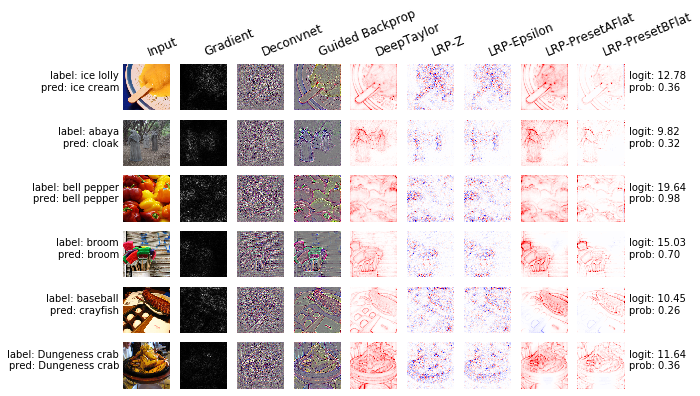

In [8]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]  
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]),'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]),'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("plot_file_name", None))

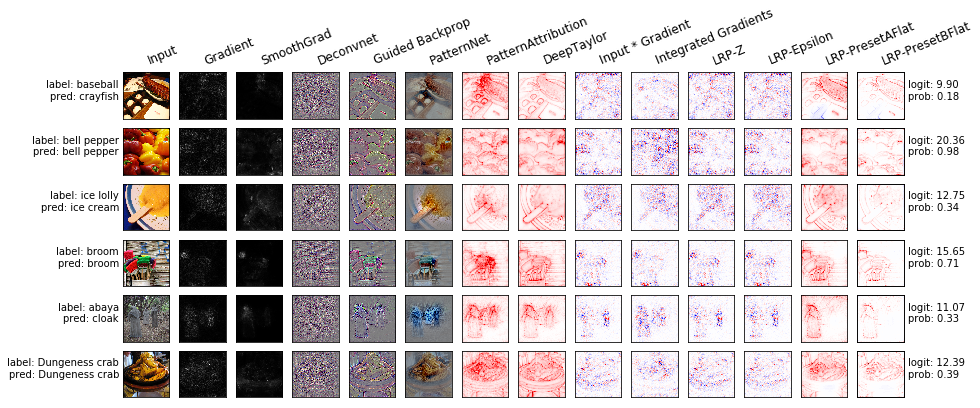

In [8]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]  
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]),'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]),'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("plot_file_name", None))

This figure shows the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).


If you are curious about how **iNNvestigate** performs on *different* ImageNet model, have a look here: [Comparing networks on ImageNet](imagenet_network_comparison.ipynb)